## Student: Jahad Jafarov
## Professor: Madalina Olteanu
## Research Paper: Hidden Markov Model for Stock Trading (author: Nguyet Nguyen)

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# In this Jupyter Notebook I'll be looking for the best Hidden Markov Model
Specifically - for the best number of states

In [3]:
symbol = '^GSPC'  # S&P 500 index ticker
start_date = '2003-12-01'
end_date = '2023-11-30'

sp500_data = yf.download(symbol, start=start_date, end=end_date, interval='1mo')

[*********************100%%**********************]  1 of 1 completed


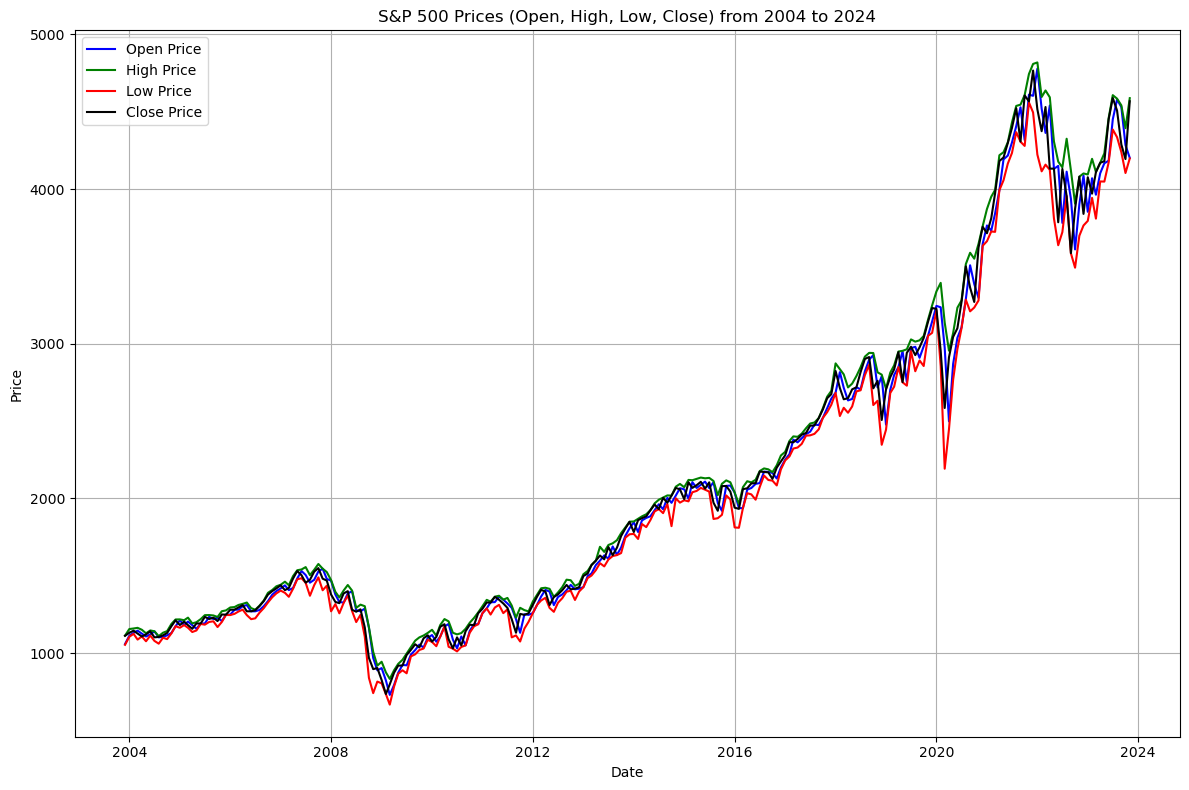

                   Open         High          Low        Close
Date                                                          
2003-12-01  1058.199951  1112.560059  1053.410034  1111.920044
2004-01-01  1111.920044  1155.380005  1105.079956  1131.130005
2004-02-01  1131.130005  1158.979980  1124.439941  1144.939941
2004-03-01  1144.939941  1163.229980  1087.160034  1126.209961
2004-04-01  1126.209961  1150.569946  1107.229980  1107.300049


In [5]:
sp500_data = sp500_data[['Open', 'High', 'Low', 'Close']]

plt.figure(figsize=(12, 8))

plt.plot(sp500_data['Open'], label='Open Price', color='blue')
plt.plot(sp500_data['High'], label='High Price', color='green')
plt.plot(sp500_data['Low'], label='Low Price', color='red')
plt.plot(sp500_data['Close'], label='Close Price', color='black')


plt.title('S&P 500 Prices (Open, High, Low, Close) from 2004 to 2024')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(sp500_data.head())


In [6]:
print(sp500_data.describe())

              Open         High          Low        Close
count   240.000000   240.000000   240.000000   240.000000
mean   2116.546328  2186.655294  2043.323126  2129.351998
std    1072.507171  1112.779826  1030.413635  1079.447515
min     729.570007   832.979980   666.789978   735.090027
25%    1269.892548  1296.902466  1240.139984  1270.172455
50%    1770.690002  1831.494995  1742.059998  1794.200012
75%    2761.272522  2863.450073  2681.962585  2766.249939
max    4778.140137  4818.620117  4560.000000  4766.180176


In [7]:
print(sp500_data.head())

                   Open         High          Low        Close
Date                                                          
2003-12-01  1058.199951  1112.560059  1053.410034  1111.920044
2004-01-01  1111.920044  1155.380005  1105.079956  1131.130005
2004-02-01  1131.130005  1158.979980  1124.439941  1144.939941
2004-03-01  1144.939941  1163.229980  1087.160034  1126.209961
2004-04-01  1126.209961  1150.569946  1107.229980  1107.300049


### For the rest of this notebook, I follow the methodology used by the author

In [9]:
# Prepare Data for 120-month blocks
block_length = 120  # 10 years of monthly data
num_blocks = len(sp500_data) - block_length + 1  # Total number of blocks

In [10]:
num_blocks

121

### I specifically use the equations set by the author, instead of functions from python libraries

In [11]:
# Define the AIC, BIC, HQC, and CAIC calculation methods
def calculate_criteria(model, X, num_parameters):
    """ Calculate AIC, BIC, HQC, and CAIC for the model """
    log_likelihood = model.score(X)
    n_samples = len(X)
    
    # AIC: Akaike Information Criterion
    AIC = -2 * log_likelihood + 2 * num_parameters
    
    # BIC: Bayesian Information Criterion
    BIC = -2 * log_likelihood + np.log(n_samples) * num_parameters
    
    # HQC: Hannan-Quinn Criterion
    HQC = -2 * log_likelihood + 2 * np.log(np.log(n_samples)) * num_parameters
    
    # CAIC: Consistent Akaike Information Criterion
    CAIC = -2 * log_likelihood + np.log(n_samples) * num_parameters + 2 * num_parameters
    
    return AIC, BIC, HQC, CAIC


This block of code takes some time...

Here I run AIC, BIC, HQC and Bozdogan CAIC tests on datasets with varying number of states (from 2 to 6) as suggested by the author

In [12]:
# Loop through the blocks and train the HMM
results = {'AIC': {2: [], 3: [], 4: [], 5: [], 6: []},
           'BIC': {2: [], 3: [], 4: [], 5: [], 6: []},
           'HQC': {2: [], 3: [], 4: [], 5: [], 6: []},
           'CAIC': {2: [], 3: [], 4: [], 5: [], 6: []}}
states_range = range(2, 7)  # Considering 2 to 6 hidden states
block_length = 120  # 120 months for each block

for i in range(num_blocks):
    # Extract the block of data (current 120 months)
    block_data = sp500_data.iloc[i:i + block_length][['Open', 'High', 'Low', 'Close']].values
    
    # Initialize results for different state configurations
    for num_states in states_range:
        # Create and fit the HMM model with Gaussian emissions
        model = GaussianHMM(n_components=num_states, covariance_type="full")
        
        # Fit the model using the block data
        model.fit(block_data)
        
        # Calculate AIC, BIC, HQC, and CAIC
        AIC, BIC, HQC, CAIC = calculate_criteria(model, block_data, num_states * (block_data.shape[1] + 1))
        
        # Append the results for this block
        results['AIC'][num_states].append(AIC)
        results['BIC'][num_states].append(BIC)
        results['HQC'][num_states].append(HQC)
        results['CAIC'][num_states].append(CAIC)


C:\Users\1jafa\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\1jafa\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. 

C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Model is not converging.  Current: -2430.6325552950693 is not greater than -2429.574918593797. Delta is -1.0576367012722585
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1ja

C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Model is not converging.  Current: -2467.4594073780436 is not greater than -2456.914536159831. Delta is -10.544871218212393
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1ja

C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\1jafa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

ValueError: transmat_ rows must sum to 1 (got row sums of [1. 1. 1. 1. 1. 0.])

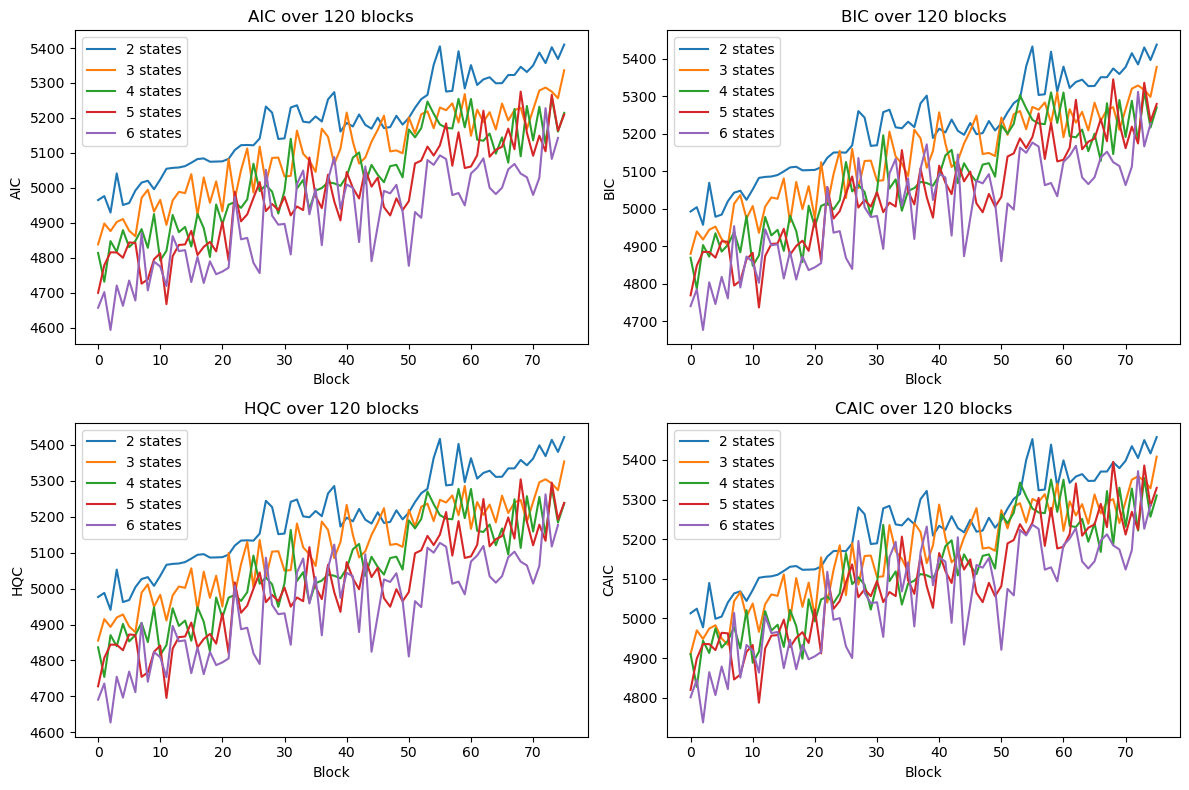

In [19]:
# Plot the results for AIC, BIC, HQC, and CAIC
plt.figure(figsize=(12, 8))

# AIC plot
plt.subplot(2, 2, 1)
for num_states in states_range:
    plt.plot(results['AIC'][num_states], label=f'{num_states} states')
plt.title('AIC over 120 blocks')
plt.xlabel('Block')
plt.ylabel('AIC')
plt.legend()

# BIC plot
plt.subplot(2, 2, 2)
for num_states in states_range:
    plt.plot(results['BIC'][num_states], label=f'{num_states} states')
plt.title('BIC over 120 blocks')
plt.xlabel('Block')
plt.ylabel('BIC')
plt.legend()

# HQC plot
plt.subplot(2, 2, 3)
for num_states in states_range:
    plt.plot(results['HQC'][num_states], label=f'{num_states} states')
plt.title('HQC over 120 blocks')
plt.xlabel('Block')
plt.ylabel('HQC')
plt.legend()

# CAIC plot
plt.subplot(2, 2, 4)
for num_states in states_range:
    plt.plot(results['CAIC'][num_states], label=f'{num_states} states')
plt.title('CAIC over 120 blocks')
plt.xlabel('Block')
plt.ylabel('CAIC')
plt.legend()

# Adjust layout for better display
plt.tight_layout()
plt.show()


# Results
The results suggest that 6 states is the most optimal

In [20]:
avg_AIC = {num_states: np.mean(results['AIC'][num_states]) for num_states in range(2, 7)}
avg_BIC = {num_states: np.mean(results['BIC'][num_states]) for num_states in range(2, 7)}
avg_HQC = {num_states: np.mean(results['HQC'][num_states]) for num_states in range(2, 7)}
avg_CAIC = {num_states: np.mean(results['CAIC'][num_states]) for num_states in range(2, 7)}

# Print the averages for each state
print("Average AIC for each state:")
for num_states in range(2, 7):
    print(f"State {num_states}: {avg_AIC[num_states]}")

print("\nAverage BIC for each state:")
for num_states in range(2, 7):
    print(f"State {num_states}: {avg_BIC[num_states]}")

print("\nAverage HQC for each state:")
for num_states in range(2, 7):
    print(f"State {num_states}: {avg_HQC[num_states]}")

print("\nAverage CAIC for each state:")
for num_states in range(2, 7):
    print(f"State {num_states}: {avg_CAIC[num_states]}")

Average AIC for each state:
State 2: 5186.498970751668
State 3: 5095.9910455637755
State 4: 5026.2830398488295
State 5: 4976.068238022667
State 6: 4910.831984236831

Average BIC for each state:
State 2: 5214.373888179488
State 3: 5137.8034217055065
State 4: 5082.0328747044705
State 5: 5045.755531592218
State 6: 4994.456736520292

Average HQC for each state:
State 2: 5197.819103346868
State 3: 5112.971244456574
State 4: 5048.923305039231
State 5: 5004.368569510667
State 6: 4944.792382022432

Average CAIC for each state:
State 2: 5234.373888179488
State 3: 5167.8034217055065
State 4: 5122.0328747044705
State 5: 5095.755531592218
State 6: 5054.456736520292


# Out-of-Sample Stock Price Prediction
Using this model with 6 states we will be predicting S&P 500

Please consult the 2nd part of this notebook for the trading code